In [1]:
import numpy as np
import constants as ct

from planning_utils import create_grid, prune_path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
def plot_final_grid(grid, path, pruned_path, start, goal):
    fig = plt.figure(figsize=(20, 20))

    plt.imshow(grid, cmap='Greys', origin='lower')

    for idx in range(len(pruned_path) - 1):
       plt.plot([pruned_path[idx][1], pruned_path[idx + 1][1]], [pruned_path[idx][0], pruned_path[idx + 1][0]], 'black' , alpha=0.5, linewidth=10)

    for point in path:
       plt.scatter(point[1], point[0], c='yellow', s=200)

    for point in pruned_path:
       plt.scatter(point[1], point[0], c='red', s=400)
    
    plt.scatter(start[1], start[0], c='blue', s=400)
    plt.scatter(goal[1], goal[0], c='blue', s=400)
    
    plt.xlabel('NORTH')
    plt.ylabel('EAST')

    plt.show()


In [3]:
# TARGET_ALTITUDE = 5
# SAFETY_DISTANCE = 5
# source = (10, 700)
# target = (800, 150)
# terminal_states = [target]
# delta = 10

# # Read in obstacle map
# data = np.loadtxt(ct.COLLIDERS_FILE, delimiter=',', dtype='Float64', skiprows=2)
# grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)

# # Transform grid to MDP representation
# grid[grid == 1] = None
# grid[grid == 0] = -0.02
# grid[target] = 1
# grid

In [4]:
grid = np.full((3, 4), -0.01)
terminal_states = [(2, 3), (1, 3)]
source = (0, 0)
target = terminal_states[0]
grid[1, 1] = None
grid[terminal_states[0]] = 1
grid[terminal_states[1]] = -1
grid

array([[-0.01, -0.01, -0.01, -0.01],
       [-0.01,   nan, -0.01, -1.  ],
       [-0.01, -0.01, -0.01,  1.  ]])

In [5]:
# Extract states, rewards from grid
states = set()
rewards = dict()
optimal_policy = dict()

numRows, numCols = grid.shape
for rowNum in range(numRows):
    for colNum in range(numCols):
        rewards[rowNum, colNum] = grid[rowNum, colNum]
        if not np.isnan(grid[rowNum, colNum]):
                    states.add((rowNum, colNum))
                
print('States:\n', states, len(states))
print('Rewards:\n', rewards, len(rewards))

States:
 {(0, 1), (1, 2), (0, 0), (1, 3), (2, 1), (2, 0), (2, 3), (2, 2), (1, 0), (0, 2), (0, 3)} 11
Rewards:
 {(0, 0): -0.01, (0, 1): -0.01, (0, 2): -0.01, (0, 3): -0.01, (1, 0): -0.01, (1, 1): nan, (1, 2): -0.01, (1, 3): -1.0, (2, 0): -0.01, (2, 1): -0.01, (2, 2): -0.01, (2, 3): 1.0} 12


In [6]:
# (0, 1) -> next col, (0, -1) -> prev col, (-1, 0) -> prev row, (1, 0) -> next row
possible_actions = [(0, 1), (0, -1), (-1, 0), (1, 0)]

def valid_actions(state):
    actions = []
    for action in possible_actions:
        new_state = (state[0] + action[0], state[1] + action[1])
        if new_state in states:
            actions.append(action)
    return actions

def transition(state, action):
    return [ \
        (0.8 if valid_action == action else 0.2 / 3.0, \
         (state[0] + valid_action[0], state[1] + valid_action[1]) \
        ) for valid_action in valid_actions(state)]

In [7]:
def value_iteration(discount_factor=0.9, epsilon=0.001):
    utilities = np.zeros((numRows, numCols))
    itr = 0
    while True:
        itr += 1
        prev_utilities = utilities.copy()
        delta = 0.0
        for state in states:
            utility_row_sums = [sum([prob * prev_utilities[new_state] \
                                     for prob, new_state in transition(state, action)]) \
                                for action in valid_actions(state)]
            utilities[state] = rewards[state] + discount_factor * max(utility_row_sums)
            
        delta = max(delta, abs(utilities[state] - prev_utilities[state]))
        print(itr, delta, epsilon * (1 - discount_factor) / discount_factor)

        if delta < epsilon * (1 - discount_factor) / discount_factor:
            return utilities

In [8]:
final_utilities = value_iteration()
final_utilities

1 0.01 0.00011111111111111109
2 0.0672 0.00011111111111111109
3 0.037079999999999995 0.00011111111111111109
4 0.013264560000000009 0.00011111111111111109
5 0.2895831648 0.00011111111111111109
6 0.024726117023999933 0.00011111111111111109
7 0.24160739989247998 0.00011111111111111109
8 0.018393420060518362 0.00011111111111111109
9 0.16618355823664754 0.00011111111111111109
10 0.012412572149673728 0.00011111111111111109
11 0.11047146094824478 0.00011111111111111109
12 0.008224304457759124 0.00011111111111111109
13 0.07295148651539118 0.00011111111111111109
14 0.005426273332033382 0.00011111111111111109
15 0.04809718245296213 0.00011111111111111109
16 0.0035768560014952655 0.00011111111111111109
17 0.03169935825967951 0.00011111111111111109
18 0.0023572929616435534 0.00011111111111111109
19 0.020890439609834832 0.00011111111111111109
20 0.0015534833133979964 0.00011111111111111109
21 0.013766937868172402 0.00011111111111111109
22 0.0010237536889371457 0.00011111111111111109
23 0.0090724697

array([[0.66669515, 0.87303623, 1.17191106, 0.88678246],
       [0.800742  , 0.        , 1.4947927 , 0.89582666],
       [1.07135698, 1.43507232, 1.9187237 , 2.43453548]])

In [9]:
def get_state_action_utility(action, state):
    return sum([prob * final_utilities[new_state] for prob, new_state in transition(state, action)])

for state in states:
    if state in terminal_states:
        continue
    valid_actions_for_state = valid_actions(state)
    state_action_utils = [get_state_action_utility(action, state) for action in valid_actions_for_state]
    max_action_util_index = state_action_utils.index(max(state_action_utils))
    optimal_policy[state] = valid_actions_for_state[max_action_util_index]
    
# action -> meaning: (0, 1) -> next col, (0, -1) -> prev col, (-1, 0) -> prev row, (1, 0) -> next row
# state, action pairs
optimal_policy

{(0, 1): (0, 1),
 (1, 2): (1, 0),
 (0, 0): (0, 1),
 (2, 1): (0, 1),
 (2, 0): (0, 1),
 (2, 2): (0, 1),
 (1, 0): (1, 0),
 (0, 2): (1, 0),
 (0, 3): (0, -1)}

In [10]:
curr_state = source
path = [curr_state]
while curr_state != target:
    action = optimal_policy[curr_state]
    curr_state = (curr_state[0] + action[0], curr_state[1] + action[1])
    
    path.append(curr_state)

print(path)

# Transform grid back to original rep
grid[np.isnan(grid)] = 1
grid[grid == -0.02] = 0
grid[terminal_states[0]] = 0
grid[terminal_states[1]] = 1
pruned_path = prune_path(path, grid)
pruned_path

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3)]


[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3)]

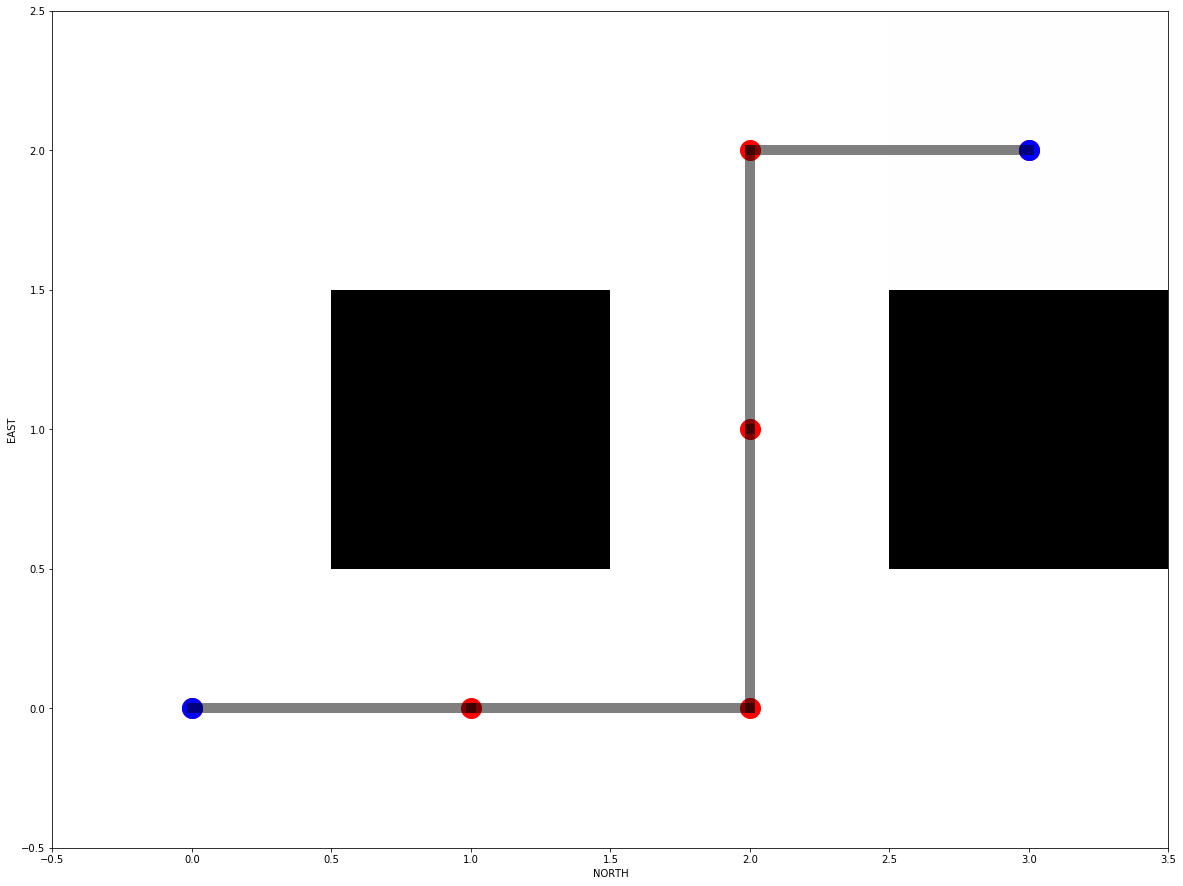

In [11]:
plot_final_grid(grid, path, pruned_path, source, target)

In [12]:
optimal_policy[0, 0]

(0, 1)